# Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).

# Answers summary
37.6 percent of riders remain active in their sixth month on the system.<br>

We built a Random Forest model with 78 percent accuracy and an XGBoost with 79 percent accuracy, and found that the most influential variables that predict retention, at least from an actionable standpoint, were cities and phone type.<br>

In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta

In [272]:
ultimate_df = pd.read_json('ultimate_data_challenge.json')

In [273]:
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [274]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Changing signup date and date of last ride to datetime.

In [275]:
ultimate_df['signup_date'] = pd.to_datetime(ultimate_df['signup_date'])
ultimate_df['last_trip_date'] = pd.to_datetime(ultimate_df['last_trip_date'])

In [276]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [277]:
ultimate_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


Looking at earliest signup date and latest trip date

In [278]:
ultimate_df['last_trip_date'].max()

Timestamp('2014-07-01 00:00:00')

In [279]:
ultimate_df['signup_date'].min()

Timestamp('2014-01-01 00:00:00')

# Looking at missing values
First let's do the easy thing. We have less than 400 observations missing the phone type. That's less than 1 percent of the data. We'll just drop rows without a phone type.

In [280]:
ultimate_df = ultimate_df.dropna(subset = ['phone'])

In [281]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  datetime64[ns]
 3   avg_rating_of_driver    41578 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  bool          
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49406 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [282]:
import missingno as msno

<AxesSubplot:>

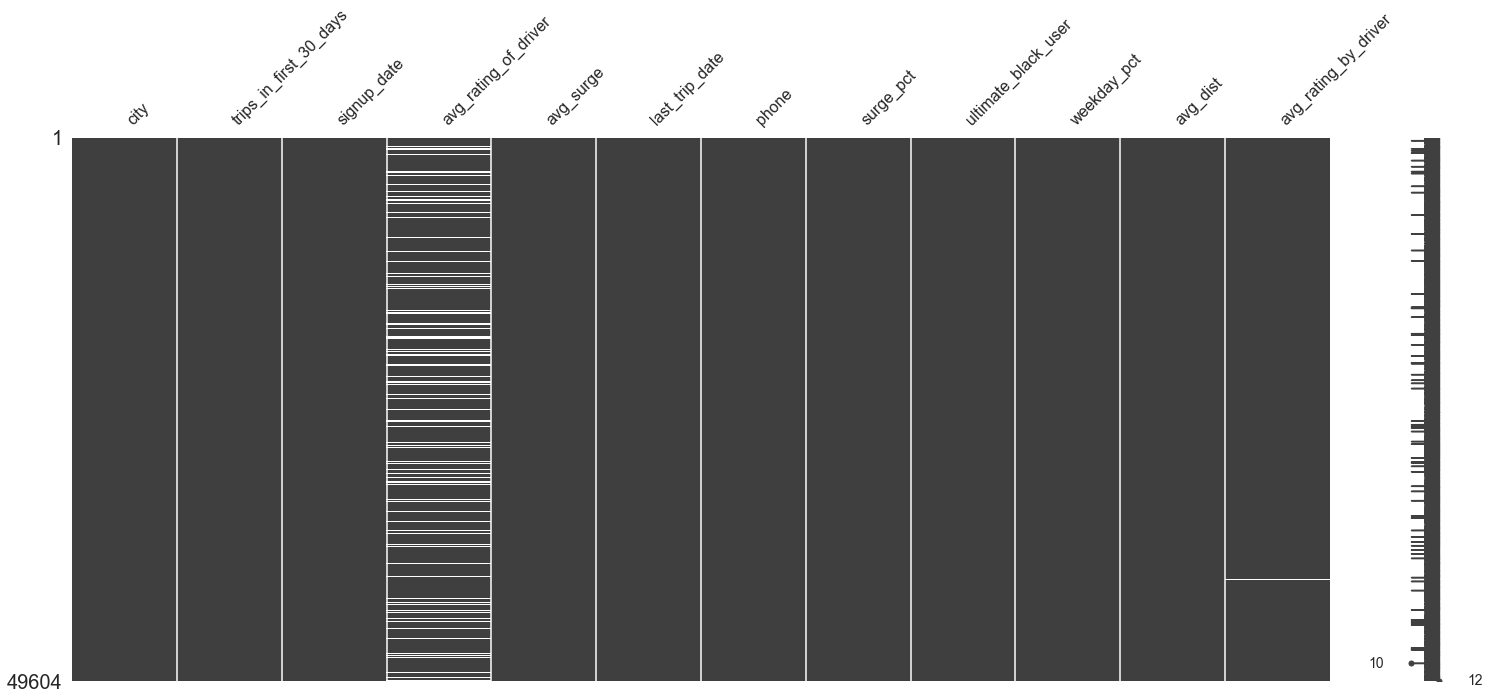

In [283]:
msno.matrix(ultimate_df)

In [284]:
missing = ultimate_df[ultimate_df['avg_rating_of_driver'].isna()]
complete = ultimate_df[~ultimate_df['avg_rating_of_driver'].isna()]

In [285]:
complete.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,41578.000000,41578.000000,41578.000000,41578.000000,41578.000000,41578.000000,41445.000000
mean,2.603252,4.601467,1.074225,8.922356,61.239338,5.460083,4.776446
std,4.054530,0.617377,0.200944,18.414864,34.872180,5.147283,0.404606
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,37.500000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.780000,5.000000
75%,3.000000,5.000000,1.070000,11.100000,100.000000,6.480000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,79.690000,5.000000


In [286]:
missing.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,8026.000000,0.0,8026.000000,8026.000000,8026.000000,8026.000000,7961.000000
mean,0.588462,NaN,1.078958,8.631622,59.042163,7.470790,4.785228
std,0.605447,NaN,0.311836,26.697303,46.871536,7.618284,0.623193
min,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,NaN,1.000000,0.000000,0.000000,2.400000,5.000000
50%,1.000000,NaN,1.000000,0.000000,100.000000,4.695000,5.000000
75%,1.000000,NaN,1.000000,0.000000,100.000000,10.680000,5.000000
max,5.000000,NaN,5.000000,100.000000,100.000000,160.960000,5.000000


# Missing driver ratings
It looks like the less active the driver was in the first 30 days of membership, the more likely it is that there will be no average driver rating.

<AxesSubplot:>

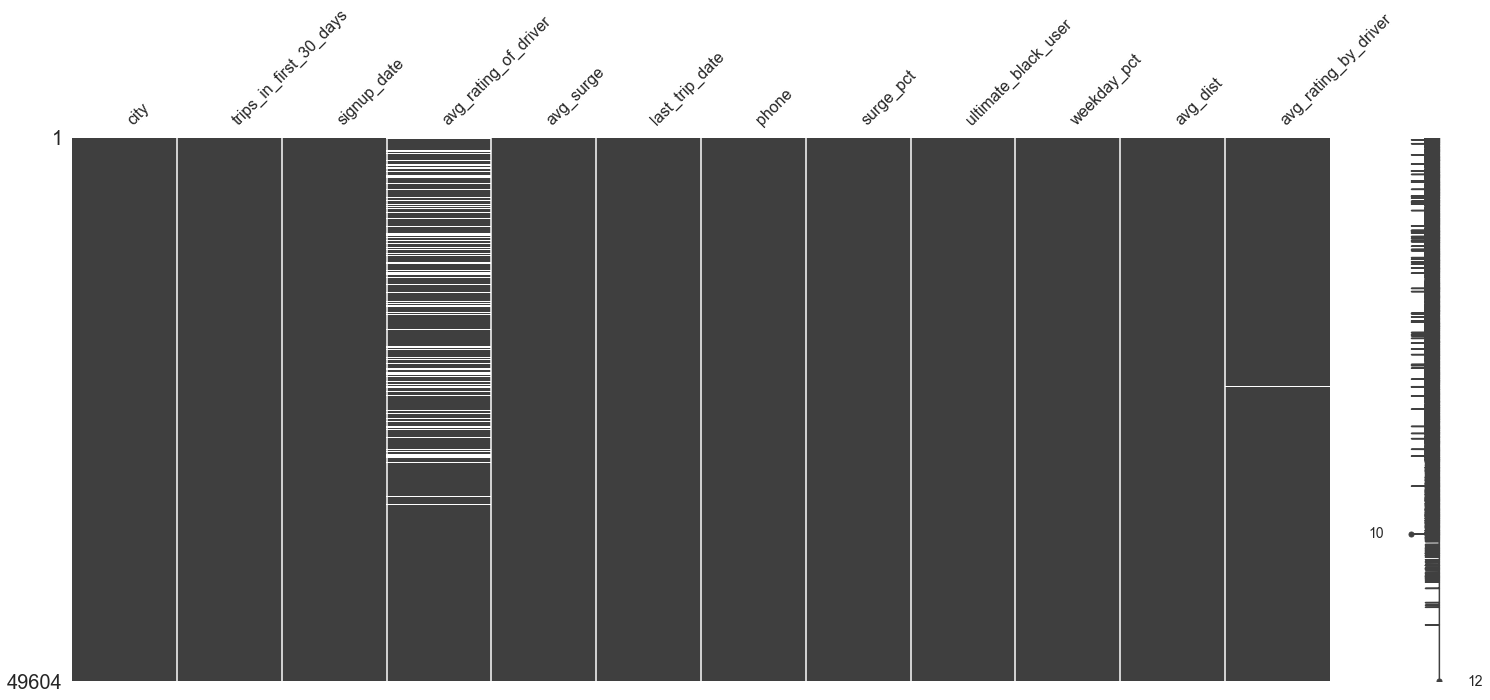

In [287]:
sorted_ultimate = ultimate_df.sort_values(by = 'trips_in_first_30_days')
msno.matrix(sorted_ultimate)

In [288]:
sorted_ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
49999,Astapor,0,2014-01-18,NaN,1.0,2014-04-20,Android,0.0,False,0.0,3.49,5.0
42979,King's Landing,0,2014-01-04,1.0,1.0,2014-04-25,iPhone,0.0,False,100.0,8.20,5.0
12704,Winterfell,0,2014-01-24,5.0,1.0,2014-03-08,Android,0.0,True,100.0,1.65,5.0
24856,Winterfell,0,2014-01-01,5.0,1.0,2014-04-16,Android,0.0,True,100.0,11.76,5.0
42976,Winterfell,0,2014-01-17,NaN,1.0,2014-05-26,iPhone,0.0,False,100.0,11.83,5.0


# Sorting by last trip date
Generally, it looks like the more recently a user took his or her last ride, the less likely it is that average driver rating will be missing. But there are still active riders who aren't rating drivers. We probably should just impute missing values with the median.

<AxesSubplot:>

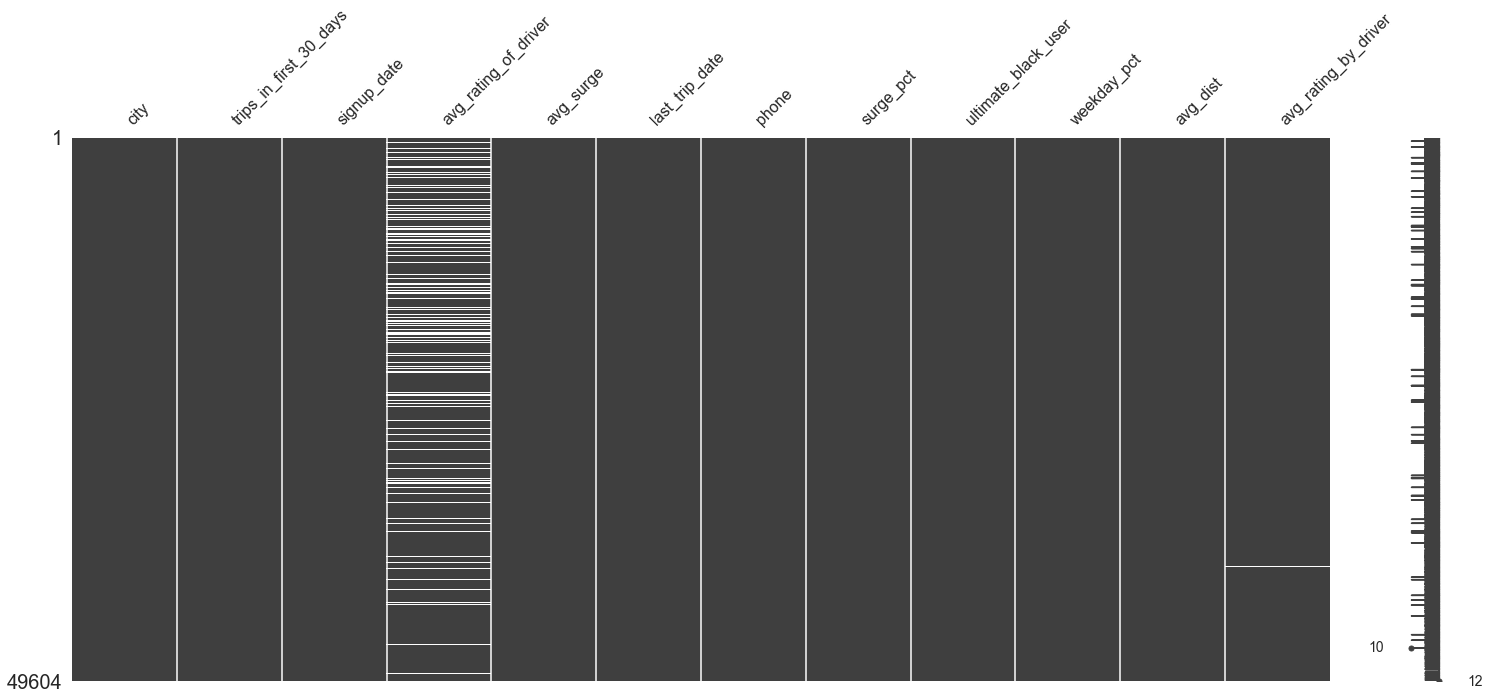

In [289]:
sorted_last30 = ultimate_df.sort_values(by = 'last_trip_date')
msno.matrix(sorted_last30)

In [290]:
rating_of_driver_med = ultimate_df['avg_rating_of_driver'].median()
rating_by_driver_med = ultimate_df['avg_rating_by_driver'].median()

In [291]:
ultimate_df = ultimate_df.fillna({'avg_rating_of_driver': rating_of_driver_med, 'avg_rating_by_driver': rating_by_driver_med})

In [292]:
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [293]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  datetime64[ns]
 3   avg_rating_of_driver    49604 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  bool          
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49604 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

# Getting our target variable
We'll create a variable to represent June 1. Any rider whose most recent ride was on or after that date is considered retained.

In [294]:
retained_cutoff = ultimate_df['last_trip_date'].max() - timedelta(days=30)

In [295]:
retained_cutoff

Timestamp('2014-06-01 00:00:00')

In [296]:
ultimate_df['retained'] = np.where(ultimate_df['last_trip_date'] >= retained_cutoff, 1, 0)

In [297]:
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [298]:
ultimate_df['retained'].value_counts(normalize = True)

0    0.623599
1    0.376401
Name: retained, dtype: float64

In [299]:
missing_check = pd.concat([ultimate_df.isnull().sum(), 100 * ultimate_df.isnull().mean()], axis=1)
missing_check.columns=['count', '%']
missing_check.sort_values(by='count', ascending=False)

,count,%
city,0,0.0
trips_in_first_30_days,0,0.0
signup_date,0,0.0
avg_rating_of_driver,0,0.0
avg_surge,0,0.0
last_trip_date,0,0.0
phone,0,0.0
surge_pct,0,0.0
ultimate_black_user,0,0.0
weekday_pct,0,0.0


Changing ultimate_black_user boolean to 1 or 0.

In [300]:
ultimate_df['ultimate_black_user'] = ultimate_df['ultimate_black_user'].astype('int')

In [301]:
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,0


# Histograms

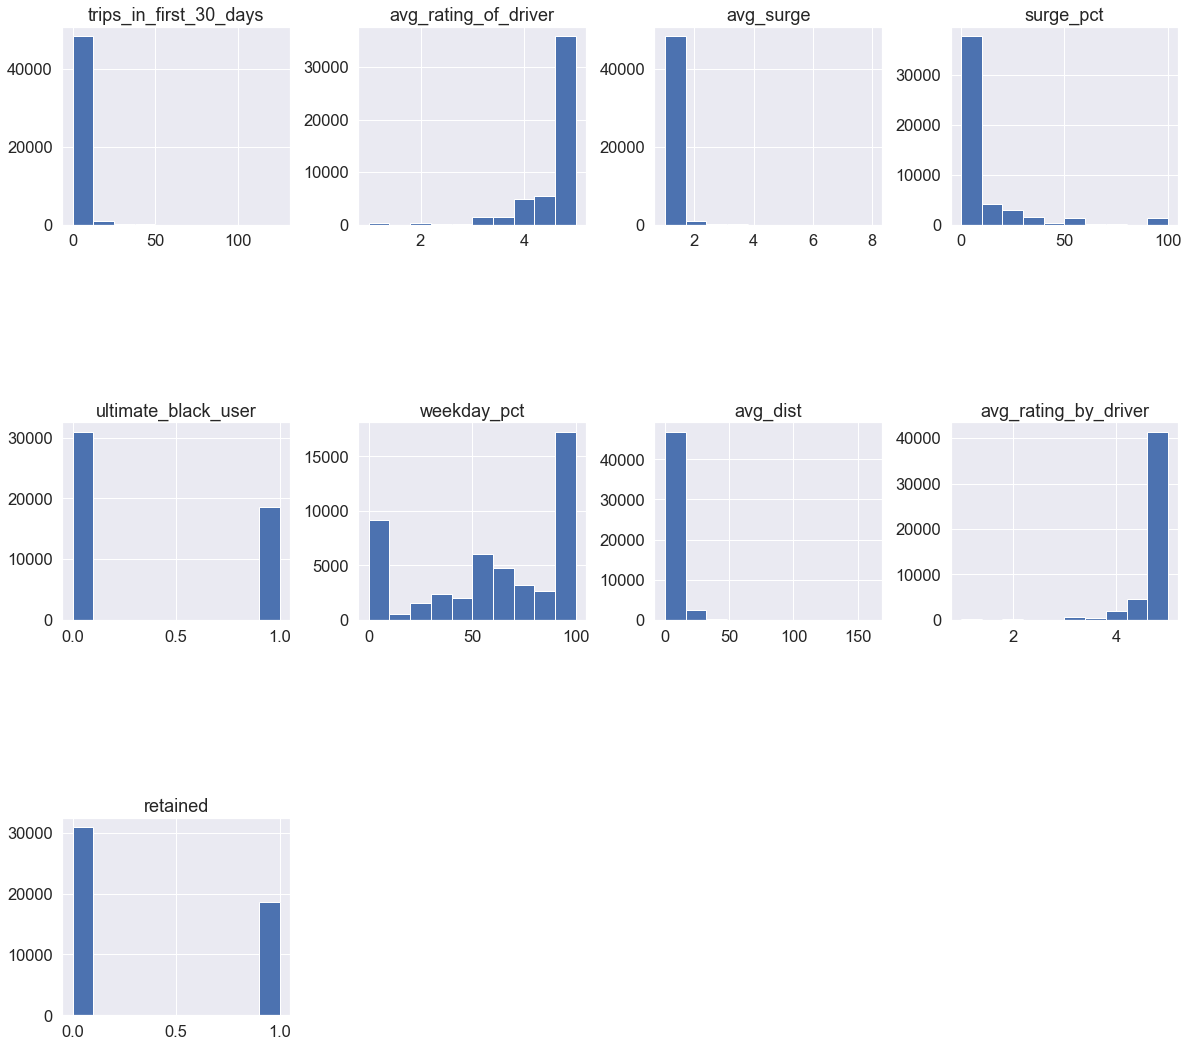

In [302]:
ultimate_df.hist(layout=(6, 4), figsize=(20,40), bins = 10)
plt.subplots_adjust(hspace=1)
plt.show()

In [303]:
ultimate_df['city'].value_counts()

Winterfell        23125
Astapor           16413
King's Landing    10066
Name: city, dtype: int64

In [304]:
ultimate_df['signup_date'].min()

Timestamp('2014-01-01 00:00:00')

In [305]:
ultimate_df['signup_date'].max()

Timestamp('2014-01-31 00:00:00')

In [306]:
ultimate_df['last_trip_date'].min()

Timestamp('2014-01-01 00:00:00')

In [307]:
ultimate_df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

One-hot encoding our categorical variables, phone and city.

In [308]:
ultimate_df = pd.get_dummies(ultimate_df, columns = ['phone', 'city'], prefix = 'cat')

In [309]:
ultimate_df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,cat_Android,cat_iPhone,cat_Astapor,cat_King's Landing,cat_Winterfell
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,1,0,1,0,1,0
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,0,1,0,1,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,0,100.0,0.77,5.0,0,0,1,1,0,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,1,0,1,0,1,0
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,0,82.4,3.13,4.9,0,1,0,0,0,1


Dropping signup_date and last_trip_date columns since everyone has signed up in January and we've derived the data we need from last_trip_date.

In [310]:
ultimate_df.drop(columns = ['signup_date', 'last_trip_date'], inplace = True)

In [311]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  49604 non-null  int64  
 1   avg_rating_of_driver    49604 non-null  float64
 2   avg_surge               49604 non-null  float64
 3   surge_pct               49604 non-null  float64
 4   ultimate_black_user     49604 non-null  int32  
 5   weekday_pct             49604 non-null  float64
 6   avg_dist                49604 non-null  float64
 7   avg_rating_by_driver    49604 non-null  float64
 8   retained                49604 non-null  int32  
 9   cat_Android             49604 non-null  uint8  
 10  cat_iPhone              49604 non-null  uint8  
 11  cat_Astapor             49604 non-null  uint8  
 12  cat_King's Landing      49604 non-null  uint8  
 13  cat_Winterfell          49604 non-null  uint8  
dtypes: float64(6), int32(2), int64(1), uin

# Heatmap
The strongest correlation with our target variable is whether or not the driver signed up in King's Landing (.26).

<AxesSubplot:>

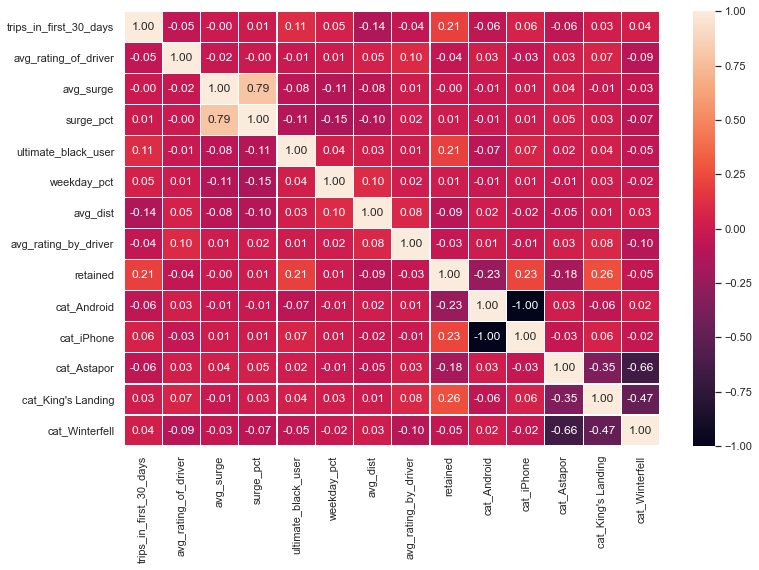

In [312]:
sns.set(rc = {'figure.figsize':(12,8)}, font_scale = 1)
corr = ultimate_df[ultimate_df.columns].corr()
#plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

# Modeling
We'll start with Random Forest.

In [313]:
from sklearn.model_selection import train_test_split 

In [314]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [315]:
X = ultimate_df.drop(columns = 'retained')
y = ultimate_df['retained']

In [316]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [317]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [318]:
X_scaled_df = pd.DataFrame(X_train, columns = X.columns)

In [319]:
X_scaled_df.head(10)

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,cat_Android,cat_iPhone,cat_Astapor,cat_King's Landing,cat_Winterfell
0,-0.605042,0.432793,-0.333381,-0.441442,-0.771138,-1.645133,-0.790801,0.495013,-0.657950,0.657950,-0.702804,-0.500927,1.064516
1,-0.340258,0.605495,-0.333381,-0.441442,-0.771138,1.050902,-0.453812,0.495013,-0.657950,0.657950,-0.702804,-0.500927,1.064516
2,0.454096,0.087390,-0.110602,0.147607,1.296784,0.258267,-0.647624,-0.624264,-0.657950,0.657950,1.422872,-0.500927,-0.939394
3,1.248450,-1.121520,-0.244269,-0.126950,-0.771138,-0.127266,0.560647,-0.400409,1.519872,-1.519872,-0.702804,-0.500927,1.064516
4,-0.340258,0.432793,0.780515,2.888185,-0.771138,-0.747354,-0.551591,-0.176553,-0.657950,0.657950,-0.702804,1.996300,-0.939394
5,1.248450,0.605495,0.379512,0.467092,1.296784,0.560223,-0.511432,-0.176553,1.519872,-1.519872,-0.702804,-0.500927,1.064516
6,-0.340258,0.605495,-0.333381,-0.441442,-0.771138,1.050902,0.550171,0.495013,-0.657950,0.657950,-0.702804,1.996300,-0.939394
7,-0.340258,0.605495,-0.333381,-0.441442,-0.771138,0.376893,0.043814,-1.743541,1.519872,-1.519872,-0.702804,1.996300,-0.939394
8,-0.075473,0.605495,-0.333381,-0.441442,-0.771138,1.050902,-0.745404,0.495013,-0.657950,0.657950,1.422872,-0.500927,-0.939394
9,4.161081,0.605495,-0.333381,-0.441442,1.296784,0.527871,1.040813,0.047302,-0.657950,0.657950,-0.702804,-0.500927,1.064516


In [320]:
X_scaled_df.mean()

trips_in_first_30_days    1.037180e-15
avg_rating_of_driver      2.615832e-15
avg_surge                 1.507242e-15
surge_pct                 9.677169e-16
ultimate_black_user       2.449896e-15
weekday_pct               3.422628e-16
avg_dist                 -1.146330e-16
avg_rating_by_driver      5.729358e-16
cat_Android               5.018098e-17
cat_iPhone               -5.018098e-17
cat_Astapor               9.763964e-16
cat_King's Landing       -5.683810e-16
cat_Winterfell            7.751929e-17
dtype: float64

In [321]:
X_scaled_df.std()

trips_in_first_30_days    1.000014
avg_rating_of_driver      1.000014
avg_surge                 1.000014
surge_pct                 1.000014
ultimate_black_user       1.000014
weekday_pct               1.000014
avg_dist                  1.000014
avg_rating_by_driver      1.000014
cat_Android               1.000014
cat_iPhone                1.000014
cat_Astapor               1.000014
cat_King's Landing        1.000014
cat_Winterfell            1.000014
dtype: float64

In [322]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [323]:
base_rf = RandomForestClassifier(random_state = 42)
base_rf.fit(X_train, y_train)
y_pred = base_rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {acc:.5f}")

Accuracy score: 0.75662


In [324]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      9320
           1       0.68      0.67      0.67      5562

    accuracy                           0.76     14882
   macro avg       0.74      0.74      0.74     14882
weighted avg       0.76      0.76      0.76     14882



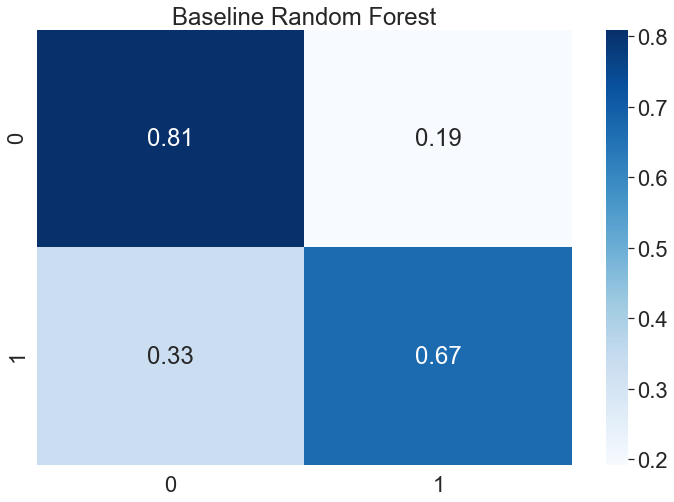

In [325]:
sns.set(rc = {'figure.figsize':(12,8)}, font_scale = 2)
base_rf_cmatrix = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(base_rf_cmatrix, annot=True, cmap = 'Blues').set(title = 'Baseline Random Forest');

In [326]:
param_grid = {'n_estimators' : [50, 100, 200], 'max_depth' : [3, 6, 9], 'max_features': ['auto', 'sqrt'],\
             'min_samples_split': [6], 'min_samples_leaf':[1, 2, 3, 4, 5]}

In [327]:
# from sklearn.model_selection import GridSearchCV
# tuned_rf = RandomForestClassifier(random_state = 42)
# rand_grid = GridSearchCV(tuned_rf, param_grid, cv = 3, n_jobs = 2, verbose = 3)
# rand_grid.fit(X_train, y_train)
# print(f"Best Accuracy: {rand_grid.best_score_:.5f}")
# print(f"Best Params: {rand_grid.best_params_}")

In [328]:
best_rf = RandomForestClassifier(n_estimators = 100, min_samples_split = 6, min_samples_leaf = 3,\
                                 max_features = 'auto', max_depth = 9, random_state = 42)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
best_rf_acc = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {best_rf_acc:.5f}")

Accuracy score: 0.78430


In [329]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      9320
           1       0.74      0.66      0.69      5562

    accuracy                           0.78     14882
   macro avg       0.77      0.76      0.76     14882
weighted avg       0.78      0.78      0.78     14882



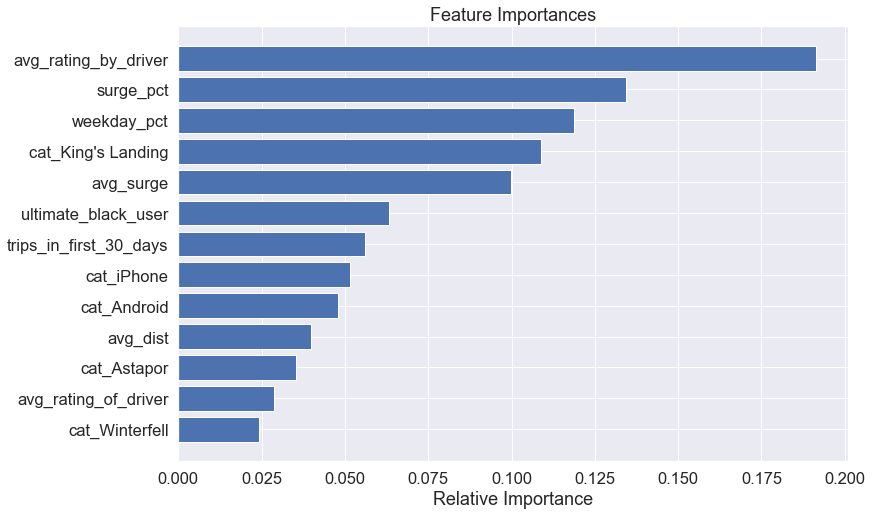

In [330]:
sns.set(rc = {'figure.figsize':(12,8)}, font_scale = 1.5)

features = X_scaled_df.columns
feat_importances = best_rf.feature_importances_
indices = np.argsort(feat_importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), feat_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# What this tells us
The strongest feature here is avg_rating_by_driver. That's not really actionable because it depends on the actions of riders during the ride and the feelings of the driver. The next two suggest that when riders use the app is strongly indicative of retention. King's Landing is interesting because it prompted us to break down retention by city.

In [331]:
kings_df = ultimate_df[ultimate_df["cat_King's Landing"] == 1]

In [332]:
kings_df['retained'].value_counts(normalize = True)

1    0.628353
0    0.371647
Name: retained, dtype: float64

In [333]:
astapor_df = ultimate_df[ultimate_df["cat_Astapor"] == 1]

In [334]:
astapor_df['retained'].value_counts(normalize = True)

0    0.744227
1    0.255773
Name: retained, dtype: float64

In [335]:
winterfell_df = ultimate_df[ultimate_df["cat_Winterfell"] == 1]

In [336]:
winterfell_df['retained'].value_counts(normalize = True)

0    0.647654
1    0.352346
Name: retained, dtype: float64

# Do we even need a model?
Look at that. 63 percent of King's Landing riders have remained active while only 26 percent of Astapor riders are still active and only 35 percent of Winterfell drivers have stayed active. Let's just look at XG Boost and see if that sheds any more light.

In [337]:
import xgboost as xgb
xgb_class = xgb.XGBClassifier(random_state = 42)
xgb_class.fit(X_train, y_train)
y_pred = xgb_class.predict(X_test)
print("Accuracy on training set:", xgb_class.score(X_train, y_train))
print("Accuracy on test set:", xgb_class.score(X_test, y_test))

C:\Users\Owner\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:59:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy on training set: 0.840014976095847
Accuracy on test set: 0.7903507593065449


In [338]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      9320
           1       0.74      0.68      0.71      5562

    accuracy                           0.79     14882
   macro avg       0.78      0.77      0.77     14882
weighted avg       0.79      0.79      0.79     14882



In [339]:
xgb_params = {'learning_rate' : [0.01, 0.1, 0.5], 'max_depth': [6, 7, 8, 9], 'colsample_bytree': [0.5, 1],\
             'n_estimators': [100, 125, 150, 175, 200, 225, 250]}

In [340]:
# tuned_xgb = xgb.XGBClassifier(random_state = 42)
# xgb_cv = GridSearchCV(tuned_xgb, xgb_params, cv = 3, n_jobs = 2, verbose = 3)
# xgb_cv.fit(X_train, y_train)
# print(f"Best Accuracy: {xgb_cv.best_score_:.5f}")
# print(f"Best Params: {xgb_cv.best_params_}")

In [341]:
best_xgb = xgb.XGBClassifier(n_estimators = 150, max_depth = 6, learning_rate = 0.1, colsample_bytree = 0.5)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
print("Accuracy on training set:", best_xgb.score(X_train, y_train))
print("Accuracy on test set:", best_xgb.score(X_test, y_test))

[14:59:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy on training set: 0.8154484188698807
Accuracy on test set: 0.792971374815213


In [342]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      9320
           1       0.74      0.68      0.71      5562

    accuracy                           0.79     14882
   macro avg       0.78      0.77      0.77     14882
weighted avg       0.79      0.79      0.79     14882



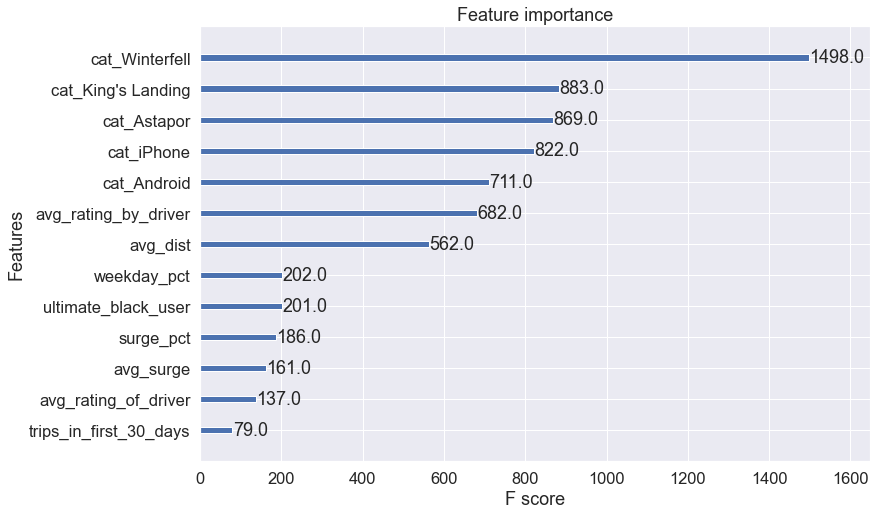

In [344]:
from xgboost import plot_importance
plot_importance(best_xgb).set_yticklabels(X.columns)
plt.show()

This confirms that city is a powerful predictor of retention, but we also should take a look at the phone type.

In [348]:
iphone_df = ultimate_df[ultimate_df['cat_iPhone'] == 1]

In [349]:
iphone_df['retained'].value_counts(normalize = True)

0    0.551067
1    0.448933
Name: retained, dtype: float64

In [350]:
android_df = ultimate_df[ultimate_df['cat_Android'] == 1]

In [351]:
android_df['retained'].value_counts(normalize = True)

0    0.790574
1    0.209426
Name: retained, dtype: float64

# Recommendations
To increase retention, provide Astapor and Winterfell riders with discount offers and also improve user experience for Android users. We can see that only 21 percent of Android users remain active after six months.